In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-07-20 19:11:31.664348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753038691.900560     100 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753038691.967071     100 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Directory paths
stone_dir = "/kaggle/input/kidney-ultrasound-images-stone-and-no-stone/my dataset final 512x512(implemented)/stone"
no_stone_dir = "/kaggle/input/kidney-ultrasound-images-stone-and-no-stone/my dataset final 512x512(implemented)/Normal"

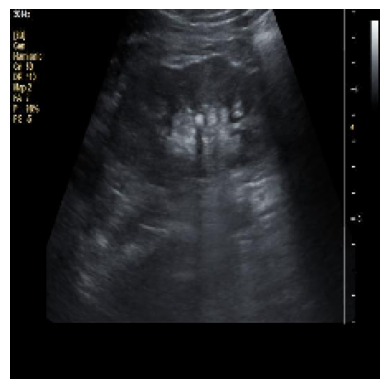

In [3]:
import matplotlib.pyplot as plt
if not os.path.exists(stone_dir):
    print(f"Directory not found: {stone_dir}")
else:
    # List files in the stone directory
    stone_files = os.listdir(stone_dir)
    if len(stone_files) > 5:
        image_path = os.path.join(stone_dir, stone_files[5])  # Take the sixth image in the directory

        # Load the image and convert it to a format suitable for display
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0  # Normalize the image (0 to 1 range)

        # Display the image
        plt.imshow(img_array)
        plt.axis('off')  # Turn off axis
        plt.show()
    else:
        print("Not enough images in the stone directory.")


In [4]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define image size for consistency
image_size = (224, 224)

# Function to load images and display them with their labels
def load_images_from_directory(directory, label):
    images = []
    labels = []

    # List files in the directory
    filenames = os.listdir(directory)
    if not filenames:
        print(f"Warning: No images found in {directory}")

    for filename in filenames:
        img_path = os.path.join(directory, filename)

        # Only process jpg or png images
        if img_path.endswith(".JPG") or img_path.endswith(".png"):
            try:
                # Load and preprocess the image
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize image values to [0, 1]

                # Append to images and labels lists
                images.append(img_array)
                labels.append(label)

                # Display the image and its label
                #plt.imshow(img_array)
                #plt.title(f"Label: {label}")  # Display the label as the title
               # plt.axis('off')  # Hide axes for a cleaner view
               # plt.show()

                #print(f"Image: {filename}, Label: {label}")
            except Exception as e:
                print(f"Error loading image {filename}: {e}")

    return images, labels


In [5]:
stone_images, stone_labels = load_images_from_directory(stone_dir, 1)
no_stone_images, no_stone_labels = load_images_from_directory(no_stone_dir, 0)

images = np.concatenate((stone_images, no_stone_images), axis=0)
labels = np.concatenate((stone_labels, no_stone_labels), axis=0)

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocess input for DenseNet
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)


In [6]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add classification layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

2025-07-20 19:13:04.867821: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_2[0][

 Total params: 4,540,565 (17.32 MB)

 Trainable params: 270,849 (1.03 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

Epoch 1/25
236/236 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.5216 - loss: 0.7054 - val_accuracy: 0.6263 - val_loss: 0.6726
Epoch 2/25
236/236 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.5767 - loss: 0.6734 - val_accuracy: 0.5393 - val_loss: 0.6594
Epoch 3/25
236/236 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.6261 - loss: 0.6566 - val_accuracy: 0.5828 - val_loss: 0.6425
Epoch 4/25
236/236 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.6819 - loss: 0.6384 - val_accuracy: 0.8567 - val_loss: 0.6253
Epoch 5/25
236/236 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.7063 - loss: 0.6211 - val_accuracy: 0.8185 - val_loss: 0.6056
Epoch 6/25
236/236 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.7373 - loss: 0.6028 - val_accuracy: 0.6720 - val_loss: 0.5874
Epoch 7/25
236/236 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.7555 - loss: 0.5830 - val_accuracy: 0.8323 - val_loss: 0.5620
Epoch 8/25
236/236 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.7828 - loss: 0.5559 - val_accu

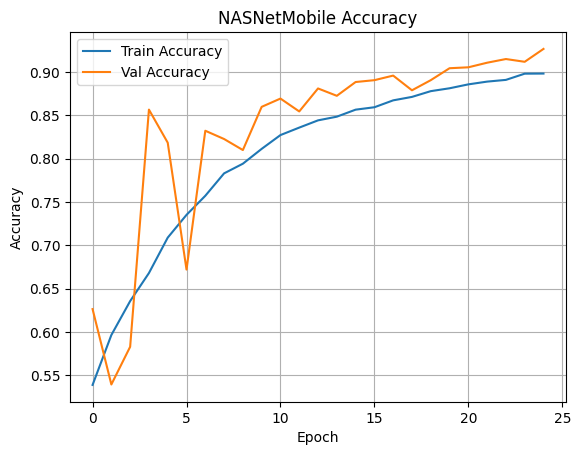

In [8]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=25,
                    batch_size=32)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('NASNetMobile Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step


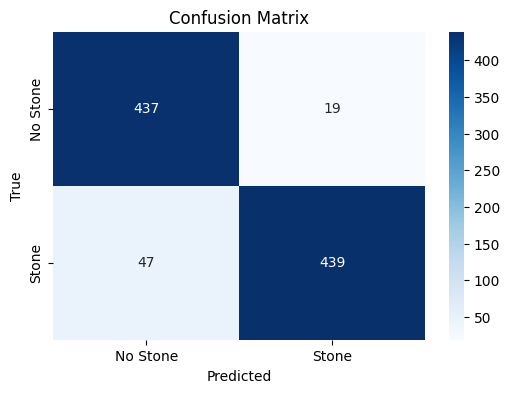

Confusion Matrix:
[[437  19]
 [ 47 439]]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions on the test data
y_pred = model.predict(X_test)

# Step 2: Threshold predictions to get binary outputs (0 or 1)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Step 4: Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stone', 'Stone'], yticklabels=['No Stone', 'Stone'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print confusion matrix values for reference
print(f"Confusion Matrix:\n{cm}")
